In [1]:
duration = 0.3

# Authors:  Dirk Gütlin <dirk.guetlin@gmail.com>
#           Nicolas Barascud
#
# License: BSD (3-clause)
"""
In asrpy.asr you can find the original ASR functions (similar to MATLAB)
as well as a high-level ASR object ready to use with MNE-Python raw data.
"""
import logging
import warnings

import numpy as np
from scipy import linalg
from numpy.linalg import pinv

########################IMPORT########################

# Authors:  Nicolas Barascud
#           Dirk Gütlin <dirk.guetlin@gmail.com>
#
# License: BSD (3-clause)
"""
In asrpy.utils you can find utility functions required to perform ASR.
"""
import numpy as np
from scipy import signal
from scipy.linalg import toeplitz
from scipy.spatial.distance import cdist, euclidean
from scipy.special import gamma, gammaincinv


def fit_eeg_distribution(X, min_clean_fraction=0.25, max_dropout_fraction=0.1,
                         fit_quantiles=[0.022, 0.6], step_sizes=[0.01, 0.01],
                         shape_range=np.arange(1.7, 3.5, 0.15)):
    """Estimate the mean and SD of clean EEG from contaminated data.

    This function estimates the mean and standard deviation of clean EEG from
    a sample of amplitude values (that have preferably been computed over
    short windows) that may include a large fraction of contaminated samples.
    The clean EEG is assumed to represent a generalized Gaussian component in
    a mixture with near-arbitrary artifact components. By default, at least
    25% (`min_clean_fraction`) of the data must be clean EEG, and the rest
    can be contaminated. No more than 10% (`max_dropout_fraction`) of the
    data is allowed to come from contaminations that cause lower-than-EEG
    amplitudes (e.g., sensor unplugged). There are no restrictions on
    artifacts causing larger-than-EEG amplitudes, i.e., virtually anything is
    handled (with the exception of a very unlikely type of distribution that
    combines with the clean EEG samples into a larger symmetric generalized
    Gaussian peak and thereby "fools" the estimator). The default parameters
    should work for a wide range of applications but may be adapted to
    accommodate special circumstances.
    The method works by fitting a truncated generalized Gaussian whose
    parameters are constrained by `min_clean_fraction`,
    `max_dropout_fraction`, `fit_quantiles`, and `shape_range`. The fit is
    performed by a grid search that always finds a close-to-optimal solution
    if the above assumptions are fulfilled.

    Parameters
    ----------
    X : array, shape=(n_channels, n_samples)
        EEG data, possibly containing artifacts.
    max_dropout_fraction : float
        Maximum fraction that can have dropouts. This is the maximum fraction
        of time windows that may have arbitrarily low amplitude (e.g., due to
        the sensors being unplugged) (default=0.25).
    min_clean_fraction : float
        Minimum fraction that needs to be clean. This is the minimum fraction
        of time windows that need to contain essentially uncontaminated EEG
        (default=0.1).
    fit_quantiles : 2-tuple
        Quantile range [lower,upper] of the truncated generalized Gaussian
        distribution that shall be fit to the EEG contents (default=[0.022
        0.6]).
    step_sizes : 2-tuple
        Step size of the grid search; the first value is the stepping of the
        lower bound (which essentially steps over any dropout samples), and
        the second value is the stepping over possible scales (i.e., clean-
        data quantiles) (default=[0.01, 0.01]).
    beta : array
        Range that the clean EEG distribution's shape parameter beta may take.

    Returns
    -------
    mu : array
        Estimated mean of the clean EEG distribution.
    sig : array
        Estimated standard deviation of the clean EEG distribution.
    alpha : float
        Estimated scale parameter of the generalized Gaussian clean EEG
        distribution.
    beta : float
        Estimated shape parameter of the generalized Gaussian clean EEG
        distribution.

    """
    # sort data so we can access quantiles directly
    X = np.sort(X)
    n = len(X)

    # compute z bounds for the truncated standard generalized Gaussian pdf and
    # pdf rescaler
    quants = np.array(fit_quantiles)
    zbounds = []
    rescale = []
    for b in range(len(shape_range)):
        gam = gammaincinv(
            1 / shape_range[b], np.sign(quants - 1 / 2) * (2 * quants - 1))
        zbounds.append(np.sign(quants - 1 / 2) * gam ** (1 / shape_range[b]))
        rescale.append(shape_range[b] / (2 * gamma(1 / shape_range[b])))

    # determine the quantile-dependent limits for the grid search
    # we can generally skip the tail below the lower quantile
    lower_min = np.min(quants)
    # maximum width is the fit interval if all data is clean
    max_width = np.diff(quants)
    # minimum width of the fit interval, as fraction of data
    min_width = min_clean_fraction * max_width

    # Build quantile interval matrix
    cols = np.arange(lower_min,
                     lower_min + max_dropout_fraction + step_sizes[0] * 1e-9,
                     step_sizes[0])
    cols = np.round(n * cols).astype(int)
    rows = np.arange(0, int(np.round(n * max_width)))
    newX = np.zeros((len(rows), len(cols)))
    for i, c in enumerate(range(len(rows))):
        newX[i] = X[c + cols]

    # subtract baseline value for each interval
    X1 = newX[0, :]
    newX = newX - X1

    opt_val = np.inf
    opt_lu = np.inf
    opt_bounds = np.inf
    opt_beta = np.inf
    gridsearch = np.round(n * np.arange(max_width, min_width, -step_sizes[1]))
    for m in gridsearch.astype(int):
        mcurr = m - 1
        nbins = int(np.round(3 * np.log2(1 + m / 2)))
        cols = nbins / newX[mcurr]
        H = newX[:m] * cols

        hist_all = []
        for ih in range(len(cols)):
            histcurr = np.histogram(H[:, ih], bins=np.arange(0, nbins + 1))
            hist_all.append(histcurr[0])
        hist_all = np.array(hist_all, dtype=int).T
        hist_all = np.vstack((hist_all, np.zeros(len(cols), dtype=int)))
        logq = np.log(hist_all + 0.01)

        # for each shape value...
        for k, b in enumerate(shape_range):
            bounds = zbounds[k]
            x = bounds[0] + np.arange(0.5, nbins + 0.5) / nbins * np.diff(bounds)  # noqa:E501
            p = np.exp(-np.abs(x) ** b) * rescale[k]
            p = p / np.sum(p)

            # calc KL divergences
            kl = np.sum(p * (np.log(p) - logq[:-1, :].T), axis=1) + np.log(m)

            # update optimal parameters
            min_val = np.min(kl)
            idx = np.argmin(kl)
            if min_val < opt_val:
                opt_val = min_val
                opt_beta = shape_range[k]
                opt_bounds = bounds
                opt_lu = [X1[idx], X1[idx] + newX[m - 1, idx]]

    # recover distribution parameters at optimum
    alpha = (opt_lu[1] - opt_lu[0]) / np.diff(opt_bounds)
    mu = opt_lu[0] - opt_bounds[0] * alpha
    beta = opt_beta

    # calculate the distribution's standard deviation from alpha and beta
    sig = np.sqrt((alpha ** 2) * gamma(3 / beta) / gamma(1 / beta))

    return mu, sig, alpha, beta


def yulewalk(order, F, M):
    """Recursive filter design using a least-squares method.

    [B,A] = YULEWALK(N,F,M) finds the N-th order recursive filter
    coefficients B and A such that the filter:
    B(z)   b(1) + b(2)z^-1 + .... + b(n)z^-(n-1)
    ---- = -------------------------------------
    A(z)    1   + a(1)z^-1 + .... + a(n)z^-(n-1)
    matches the magnitude frequency response given by vectors F and M.
    The YULEWALK function performs a least squares fit in the time domain. The
    denominator coefficients {a(1),...,a(NA)} are computed by the so called
    "modified Yule Walker" equations, using NR correlation coefficients
    computed by inverse Fourier transformation of the specified frequency
    response H.
    The numerator is computed by a four step procedure. First, a numerator
    polynomial corresponding to an additive decomposition of the power
    frequency response is computed. Next, the complete frequency response
    corresponding to the numerator and denominator polynomials is evaluated.
    Then a spectral factorization technique is used to obtain the impulse
    response of the filter. Finally, the numerator polynomial is obtained by a
    least squares fit to this impulse response. For a more detailed
    explanation of the algorithm see [1]_.

    Parameters
    ----------
    order : int
        Filter order.
    F : array
        Normalised frequency breakpoints for the filter. The frequencies in F
        must be between 0.0 and 1.0, with 1.0 corresponding to half the sample
        rate. They must be in increasing order and start with 0.0 and end with
        1.0.
    M : array
        Magnitude breakpoints for the filter such that PLOT(F,M) would show a
        plot of the desired frequency response.

    References
    ----------
    .. [1] B. Friedlander and B. Porat, "The Modified Yule-Walker Method of
           ARMA Spectral Estimation," IEEE Transactions on Aerospace
           Electronic Systems, Vol. AES-20, No. 2, pp. 158-173, March 1984.

    Examples
    --------
    Design an 8th-order lowpass filter and overplot the desired
    frequency response with the actual frequency response:
    >>> f = [0, .6, .6, 1]         # Frequency breakpoints
    >>> m = [1, 1, 0, 0]           # Magnitude breakpoints
    >>> [b, a] = yulewalk(8, f, m) # Filter design using least-squares method

    """
    F = np.asarray(F)
    M = np.asarray(M)
    npt = 512
    lap = np.fix(npt / 25).astype(int)
    mf = F.size
    npt = npt + 1  # For [dc 1 2 ... nyquist].
    Ht = np.array(np.zeros((1, npt)))
    nint = mf - 1
    df = np.diff(F)

    nb = 0
    Ht[0][0] = M[0]
    for i in range(nint):
        if df[i] == 0:
            nb = nb - int(lap / 2)
            ne = nb + lap
        else:
            ne = int(np.fix(F[i + 1] * npt)) - 1

        j = np.arange(nb, ne + 1)
        if ne == nb:
            inc = 0
        else:
            inc = (j - nb) / (ne - nb)

        Ht[0][nb:ne + 1] = np.array(inc * M[i + 1] + (1 - inc) * M[i])
        nb = ne + 1

    Ht = np.concatenate((Ht, Ht[0][-2:0:-1]), axis=None)
    n = Ht.size
    n2 = np.fix((n + 1) / 2)
    nb = order
    nr = 4 * order
    nt = np.arange(0, nr)

    # compute correlation function of magnitude squared response
    R = np.real(np.fft.ifft(Ht * Ht))
    R = R[0:nr] * (0.54 + 0.46 * np.cos(np.pi * nt / (nr - 1)))   # pick NR correlations  # noqa

    # Form window to be used in extracting the right "wing" of two-sided
    # covariance sequence
    Rwindow = np.concatenate(
        (1 / 2, np.ones((1, int(n2 - 1))), np.zeros((1, int(n - n2)))),
        axis=None)
    A = polystab(denf(R, order))  # compute denominator

    # compute additive decomposition
    Qh = numf(np.concatenate((R[0] / 2, R[1:nr]), axis=None), A, order)

    # compute impulse response
    _, Ss = 2 * np.real(signal.freqz(Qh, A, worN=n, whole=True))

    hh = np.fft.ifft(
        np.exp(np.fft.fft(Rwindow * np.fft.ifft(np.log(Ss, dtype=np.complex128))))  # noqa
    )
    B = np.real(numf(hh[0:nr], A, nb))

    return B, A


def yulewalk_filter(X, sfreq, zi=None, ab=None, axis=-1):
    """Yulewalk filter.

    Parameters
    ----------
    X : array, shape = (n_channels, n_samples)
        Data to filter.
    sfreq : float
        Sampling frequency.
    zi : array, shape=(n_channels, filter_order)
        Initial conditions.
    a, b : 2-tuple | None
        Coefficients of an IIR filter that is used to shape the spectrum of
        the signal when calculating artifact statistics. The output signal
        does not go through this filter. This is an optional way to tune the
        sensitivity of the algorithm to each frequency component of the
        signal. The default filter is less sensitive at alpha and beta
        frequencies and more sensitive at delta (blinks) and gamma (muscle)
        frequencies.
    axis : int
        Axis to filter on (default=-1, corresponding to samples).

    Returns
    -------
    out : array
        Filtered data.
    zf :  array, shape=(n_channels, filter_order)
        Output filter state.
    """
    # Set default IIR filter coefficients
    if ab is None:
        F = np.array([0, 2, 3, 13, 16, 40, np.minimum(
            80.0, (sfreq / 2.0) - 1.0), sfreq / 2.0]) * 2.0 / sfreq
        M = np.array([3, 0.75, 0.33, 0.33, 1, 1, 3, 3])
        B, A = yulewalk(8, F, M)
    else:
        A, B = ab

    # apply the signal shaping filter and initialize the IIR filter state
    if zi is None:
        out = signal.lfilter(B, A, X, axis=axis)
        zf = None
    else:
        out, zf = signal.lfilter(B, A, X, zi=zi, axis=axis)

    return out, zf


def ma_filter(N, X, Zi):
    """Run a moving average filter over the data.

    Parameters
    ----------
    N : int
        Length of the filter.
    X : array, shape=(n_channels, n_samples)
        The raw data.
    Zi : array
        The initial filter conditions.

    Returns
    -------
    X : array
        The filtered data.
    Zf : array
        The new fiter conditions.
    """
    if Zi is None:
        Zi = np.zeros([len(X), N])

    Y = np.concatenate([Zi, X], axis=1)
    M = Y.shape[-1]
    I_ = np.stack([np.arange(M - N),
                   np.arange(N, M)]).astype(int)
    S = (np.stack([-np.ones(M - N),
                   np.ones(M - N)]) / N)
    X = np.cumsum(np.multiply(Y[:, np.reshape(I_.T, -1)],
                              np.reshape(S.T, [-1])), axis=-1)

    X = X[:, 1::2]

    Zf = np.concatenate([-(X[:, -1] * N - Y[:, -N])[:, np.newaxis],
                         Y[:, -N + 1:]], axis=-1)
    return X, Zf


def geometric_median(X, tol=1e-5, max_iter=500):
    """Geometric median.

    This code is adapted from [2]_ using the Vardi and Zhang algorithm
    described in [1]_.

    Parameters
    ----------
    X : array, shape=(n_observations, n_variables)
        The data.
    tol : float
        Tolerance (default=1.e-5)
    max_iter : int
        Max number of iterations (default=500):

    Returns
    -------
    y1 : array, shape=(n_variables,)
        Geometric median over X.

    References
    ----------
    .. [1] Vardi, Y., & Zhang, C. H. (2000). The multivariate L1-median and
       associated data depth. Proceedings of the National Academy of Sciences,
       97(4), 1423-1426. https://doi.org/10.1073/pnas.97.4.1423
    .. [2] https://stackoverflow.com/questions/30299267/

    """
    y = np.mean(X, 0)  # initial value

    i = 0
    while i < max_iter:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1. / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros / r
            y1 = max(0, 1 - rinv) * T + min(1, rinv) * y

        if euclidean(y, y1) < tol:
            return y1

        y = y1
        i += 1
    else:
        print(f"Geometric median could converge in {i} iterations "
              f"with a tolerance of {tol}")


def polystab(a):
    """Polynomial stabilization.

    POLYSTAB(A), where A is a vector of polynomial coefficients,
    stabilizes the polynomial with respect to the unit circle;
    roots whose magnitudes are greater than one are reflected
    inside the unit circle.

    Parameters
    ----------
    a : array
        The vector of polynomial coefficients.

    Returns
    -------
    b : array
        The stabilized polynomial.

    Examples
    --------
    Convert a linear-phase filter into a minimum-phase filter with the same
    magnitude response.
    >>> h = fir1(25,0.4);               # Window-based FIR filter design
    >>> flag_linphase = islinphase(h)   # Determines if filter is linear phase
    >>> hmin = polystab(h) * norm(h)/norm(polystab(h));
    >>> flag_minphase = isminphase(hmin)# Determines if filter is min phase

    """
    v = np.roots(a)
    i = np.where(v != 0)
    vs = 0.5 * (np.sign(np.abs(v[i]) - 1) + 1)
    v[i] = (1 - vs) * v[i] + vs / np.conj(v[i])
    ind = np.where(a != 0)
    b = a[ind[0][0]] * np.poly(v)

    # Return only real coefficients if input was real:
    if not(np.sum(np.imag(a))):
        b = np.real(b)

    return b


def numf(h, a, nb):
    """Get numerator B given impulse-response h of B/A and denominator A."""
    nh = np.max(h.size)
    xn = np.concatenate((1, np.zeros((1, nh - 1))), axis=None)
    impr = signal.lfilter(np.array([1.0]), a, xn)

    b = np.linalg.lstsq(
        toeplitz(impr, np.concatenate((1, np.zeros((1, nb))), axis=None)),
        h.T, rcond=None)[0].T

    return b


def denf(R, na):
    """Compute order NA denominator A from covariances R(0)...R(nr)."""
    nr = np.max(np.size(R))
    Rm = toeplitz(R[na:nr - 1], R[na:0:-1])
    Rhs = - R[na + 1:nr]
    A = np.concatenate(
        (1, np.linalg.lstsq(Rm, Rhs.T, rcond=None)[0].T), axis=None)
    return A


def block_covariance(data, window=128):
    """Compute blockwise covariance.

    Parameters
    ----------
    data : array, shape=(n_chans, n_samples)
        Input data (must be 2D)
    window : int
        Window size.

    Returns
    -------
    cov : array, shape=(n_blocks, n_chans, n_chans)
        Block covariance.
    """
    n_ch, n_times = data.shape
    U = np.zeros([len(np.arange(0, n_times - 1, window)), n_ch**2])
    data = data.T
    for k in range(0, window):
        idx_range = np.minimum(n_times - 1,
                               np.arange(k, n_times + k - 2, window))
        U = U + np.reshape(data[idx_range].reshape([-1, 1, n_ch]) *
                           data[idx_range].reshape(-1, n_ch, 1), U.shape)

    return np.array(U)


########################IMPORT########################

class ASR():
    """Artifact Subspace Reconstruction.

    Artifact subspace reconstruction (ASR) is an automated, online,
    component-based artifact removal method for removing transient or
    large-amplitude artifacts in multi-channel EEG recordings [1]_.

    Parameters
    ----------
    sfreq : float
        Sampling rate of the data, in Hz.
    cutoff: float
        Standard deviation cutoff for rejection. X portions whose variance
        is larger than this threshold relative to the calibration data are
        considered missing data and will be removed. The most aggressive value
        that can be used without losing too much EEG is 2.5. Recommended to
        use with more conservative values ranging from 20 - 30.
        Defaults to 20.
    blocksize : int
        Block size for calculating the robust data covariance and thresholds,
        in samples; allows to reduce the memory and time requirements of the
        robust estimators by this factor (down to Channels x Channels x Samples
        x 16 / Blocksize bytes) (default=100).
    win_len : float
        Window length (s) that is used to check the data for artifact content.
        This is ideally as long as the expected time scale of the artifacts but
        not shorter than half a cycle of the high-pass filter that was used
        (default=0.5).
    win_overlap : float
        Window overlap fraction. The fraction of two successive windows that
        overlaps. Higher overlap ensures that fewer artifact portions are going
        to be missed, but is slower (default=0.66).
    max_dropout_fraction : float
        Maximum fraction of windows that can be subject to signal dropouts
        (e.g., sensor unplugged), used for threshold estimation (default=0.1).
    min_clean_fraction : float
        Minimum fraction of windows that need to be clean, used for threshold
        estimation (default=0.25).
    ab : 2-tuple | None
        Coefficients (A, B) of an IIR filter that is used to shape the
        spectrum of the signal when calculating artifact statistics. The
        output signal does not go through this filter. This is an optional way
        to tune the sensitivity of the algorithm to each frequency component
        of the signal. The default filter is less sensitive at alpha and beta
        frequencies and more sensitive at delta (blinks) and gamma (muscle)
        frequencies. Defaults to None.
    max_bad_chans : float
        The maximum number or fraction of bad channels that a retained window
        may still contain (more than this and it is removed). Reasonable range
        is 0.05 (very clean output) to 0.3 (very lax cleaning of only coarse
        artifacts) (default=0.2).
    method : {'riemann', 'euclid'}
        Method to use. If riemann, use the riemannian-modified version of
        ASR [2]_. Currently, only euclidean ASR is supported. Defaults to
        "euclid".

    Attributes
    ----------
    sfreq: array, shape=(n_channels, filter_order)
        Filter initial conditions.
    cutoff: float
        Standard deviation cutoff for rejection.
    blocksize : int
        Block size for calculating the robust data covariance and thresholds.
    win_len : float
        Window length (s) that is used to check the data for artifact content.
    win_overlap : float
        Window overlap fraction.
    max_dropout_fraction : float
        Maximum fraction of windows that can be subject to signal dropouts.
    min_clean_fraction : float
        Minimum fraction of windows.
    max_bad_chans : float
        The maximum fraction of bad channels.
    method : {'riemann', 'euclid'}
        Method to use.
    A, B: arrays
        Coefficients of an IIR filter that is used to shape the spectrum of the
        signal when calculating artifact statistics. The output signal does not
        go through this filter. This is an optional way to tune the sensitivity
        of the algorithm to each frequency component of the signal. The default
        filter is less sensitive at alpha and beta frequencies and more
        sensitive at delta (blinks) and gamma (muscle) frequencies.
    M : array, shape=(channels, channels)
        The mixing matrix to fit ASR data.
    T : array, shape=(channels, channels)
        The mixing matrix to fit ASR data.

    References
    ----------
    .. [1] Kothe, C. A. E., & Jung, T. P. (2016). U.S. Patent Application No.
       14/895,440. https://patents.google.com/patent/US20160113587A1/en
    .. [2] Blum, S., Jacobsen, N. S. J., Bleichner, M. G., & Debener, S.
       (2019). A Riemannian Modification of Artifact Subspace Reconstruction
       for EEG Artifact Handling. Frontiers in Human Neuroscience, 13.
       https://doi.org/10.3389/fnhum.2019.00141

    """

    def __init__(self, sfreq, cutoff=20, blocksize=100, win_len=0.5,
                 win_overlap=0.66, max_dropout_fraction=0.1,
                 min_clean_fraction=0.25, ab=None, max_bad_chans=0.1,
                 method="euclid"):

        # set attributes
        self.sfreq = sfreq
        self.cutoff = cutoff
        self.blocksize = blocksize
        self.win_len = win_len
        self.win_overlap = win_overlap
        self.max_dropout_fraction = max_dropout_fraction
        self.min_clean_fraction = min_clean_fraction
        self.max_bad_chans = max_bad_chans
        self.method = "euclid"  # NOTE: riemann is not yet available
        self._fitted = False

        # set default yule-walker filter
        if ab is None:
            yw_f = np.array([0, 2, 3, 13, 16, 40,
                             np.minimum(80.0, (self.sfreq / 2.0) - 1.0),
                             self.sfreq / 2.0]) * 2.0 / self.sfreq
            yw_m = np.array([3, 0.75, 0.33, 0.33, 1, 1, 3, 3])
            self.B, self.A = yulewalk(8, yw_f, yw_m)
        else:
            self.A, self.B = ab

        self._reset()

    def _reset(self):
        """Reset state variables."""
        self.M = None
        self.T = None

        # TODO: The following parameters are effectively not used. Still,
        #  they can be set manually via asr.transform(return_states=True)
        self.R = None
        self.carry = None
        self.Zi = None
        self.cov = None
        self._fitted = False

    def fit(self, raw, picks="eeg", start=0, stop=None,
            return_clean_window=False):
        """Calibration for the Artifact Subspace Reconstruction method.

        The input to this data is a multi-channel time series of calibration
        data. In typical uses the calibration data is clean resting EEG data
        of data if the fraction of artifact content is below the breakdown
        point of the robust statistics used for estimation (50% theoretical,
        ~30% practical). If the data has a proportion of more than 30-50%
        artifacts then bad time windows should be removed beforehand. This
        data is used to estimate the thresholds that are used by the ASR
        processing function to identify and remove artifact components.

        The calibration data must have been recorded for the same cap design
        from which data for cleanup will be recorded, and ideally should be
        from the same session and same subject, but it is possible to reuse
        the calibration data from a previous session and montage to the
        extent that the cap is placed in the same location (where loss in
        accuracy is more or less proportional to the mismatch in cap
        placement).

        Parameters
        ----------
        raw : instance of mne.io.Raw
            Instance of mne.io.Raw to be used for fitting the ASR.
            The calibration data should have been high-pass filtered (for
            example at 0.5Hz or 1Hz using a Butterworth IIR filter), and be
            reasonably clean not less than 30 seconds (this method is
            typically used with 1 minute or more).
        picks : str | list | slice | None
            Channels used to fit the ASR. All channels should be of the same
            type (e.g. "eeg", "grads"). Slices and lists of integers will
            be interpreted as channel indices. In lists, channel
            name strings (e.g., ['MEG0111', 'MEG2623'] will pick the given
            channels. Note that channels in info['bads'] will be included if
            their names or indices are explicitly provided. Defaults to "eeg".
        start : int
            The first sample to use for fitting the data. Defaults to 0.
        stop : int | None
            The last sample to use for fitting the data. If `None`, all
            samples after `start` will be used for fitting. Defaults to None.
        return_clean_window : Bool
            If True, the method will return the variables `clean` (the cropped
             dataset which was used to fit the ASR) and `sample_mask` (a
             logical mask of which samples were included/excluded from fitting
             the ASR). Defaults to False.

        Returns
        -------
        clean : array, shape=(n_channels, n_samples)
            The cropped version of the dataset which was used to calibrate
            the ASR. This array is a result of the `clean_windows` function
            and no ASR was applied to it.
        sample_mask : boolean array, shape=(1, n_samples)
            Logical mask of the samples which were used to train the ASR.

        """

        # extract the data
        X = raw.get_data(picks=picks, start=start, stop=stop)

        # Find artifact-free windows first
        clean, sample_mask = clean_windows(
            X,
            sfreq=self.sfreq,
            win_len=self.win_len,
            win_overlap=self.win_overlap,
            max_bad_chans=self.max_bad_chans,
            min_clean_fraction=self.min_clean_fraction,
            max_dropout_fraction=self.max_dropout_fraction)

        # Perform calibration
        self.M, self.T = asr_calibrate(
            clean,
            sfreq=self.sfreq,
            cutoff=self.cutoff,
            blocksize=self.blocksize,
            win_len=self.win_len,
            win_overlap=self.win_overlap,
            max_dropout_fraction=self.max_dropout_fraction,
            min_clean_fraction=self.min_clean_fraction,
            ab=(self.A, self.B),
            method=self.method)

        self._fitted = True

        # return data if required
        if return_clean_window:
            return clean, sample_mask

    def transform(self, raw, picks="eeg", lookahead=0.25, stepsize=32,
                  maxdims=0.66, return_states=False, mem_splits=3):
        """Apply Artifact Subspace Reconstruction.

        Parameters
        ----------
        raw : instance of mne.io.Raw
            Instance of mne.io.Raw to be transformed by the ASR.
        picks : str | list | slice | None
            Channels to be transformed by the ASR. Should be the same set of
            channels as used by `ASR.fit()`. All channels should be of the
            same type (e.g. "eeg", "grads"). Slices and lists of integers will
            be interpreted as channel indices. In lists, channel
            name strings (e.g., ['MEG0111', 'MEG2623'] will pick the given
            channels. Note that channels in info['bads'] will be included if
            their names or indices are explicitly provided. Defaults to "eeg".
        lookahead : float
            Amount of look-ahead that the algorithm should use (in seconds).
            This value should be between 0 (no lookahead) and WindowLength/2
            (optimal lookahead). The recommended value is WindowLength/2.
            Default: 0.25

            Note: Other than in `asr_process`, the signal will be readjusted
            to eliminate any temporal jitter and automatically readjust it to
            the correct time points. Zero-padding will be applied to the last
            `lookahead` portion of the data, possibly resulting in inaccuracies
            for the final `lookahead` seconds of the recording.
        stepsize : int
            The steps in which the algorithm will be updated. The larger this
            is, the faster the algorithm will be. The value must not be larger
            than WindowLength * SamplingRate. The minimum value is 1 (update
            for every sample) while a good value would be sfreq//3. Note that
            an update is always performed also on the first and last sample of
            the data chunk. Default: 32
        max_dims : float, int
            Maximum dimensionality of artifacts to remove. This parameter
            denotes the maximum number of dimensions which can be removed from
            each segment. If larger than 1, `int(max_dims)` will denote the
            maximum number of dimensions removed from the data. If smaller
            than 1, `max_dims` describes a fraction of total dimensions.
            Defaults to 0.66.
        return_states : bool
            If True, returns a dict including the updated states {"M":M,
            "T":T, "R":R, "Zi":Zi, "cov":cov, "carry":carry}. Defaults to
            False.
        mem_splits : int
            Split the array in `mem_splits` segments to save memory.

        Returns
        -------
        out : array, shape=(n_channels, n_samples)
            Filtered data.

        """
        # extract the data
        X = raw.get_data(picks=picks)

        # add lookahead padding at the end
        lookahead_samples = int(self.sfreq * lookahead)
        X = np.concatenate([X,
                            np.zeros([X.shape[0], lookahead_samples])],
                          axis=1)

        # apply ASR
        X = asr_process(X, self.sfreq, self.M, self.T, self.win_len,
                        lookahead, stepsize, maxdims, (self.A, self.B),
                        self.R, self.Zi, self.cov, self.carry,
                        return_states, self.method, mem_splits)

        # remove lookahead portion from start
        X = X[:, lookahead_samples:]

        # Return a modifier raw instance
        raw = raw.copy()
        raw.apply_function(lambda x: X, picks=picks,
                           channel_wise=False)
        return raw


def asr_calibrate(X, sfreq, cutoff=20, blocksize=100, win_len=0.5,
                  win_overlap=0.66, max_dropout_fraction=0.1,
                  min_clean_fraction=0.25, ab=None, method='euclid'):
    """Calibration function for the Artifact Subspace Reconstruction method.

    This function can be used if you inted to apply ASR to a simple numpy
    array instead of a mne.io.Raw object. It is equivalent to the MATLAB
    implementation of asr_calibrate (except for some small differences
    introduced by solvers for the eigenspace functions etc).

    The input to this data is a multi-channel time series of calibration data.
    In typical uses the calibration data is clean resting EEG data of ca. 1
    minute duration (can also be longer). One can also use on-task data if the
    fraction of artifact content is below the breakdown point of the robust
    statistics used for estimation (50% theoretical, ~30% practical). If the
    data has a proportion of more than 30-50% artifacts then bad time windows
    should be removed beforehand. This data is used to estimate the thresholds
    that are used by the ASR processing function to identify and remove
    artifact components.

    The calibration data must have been recorded for the same cap design from
    which data for cleanup will be recorded, and ideally should be from the
    same session and same subject, but it is possible to reuse the calibration
    data from a previous session and montage to the extent that the cap is
    placed in the same location (where loss in accuracy is more or less
    proportional to the mismatch in cap placement).

    The calibration data should have been high-pass filtered (for example at
    0.5Hz or 1Hz using a Butterworth IIR filter).

    Parameters
    ----------
    X : array, shape=(n_channels, n_samples)
        *zero-mean* (e.g., high-pass filtered) and reasonably clean EEG of not
        much less than 30 seconds (this method is typically used with 1 minute
        or more).
    sfreq : float
        Sampling rate of the data, in Hz.
    cutoff: float
        Standard deviation cutoff for rejection. X portions whose variance
        is larger than this threshold relative to the calibration data are
        considered missing data and will be removed. Defaults to 20
        (In EEGLab's `clean_rawdata` the original threshold was set to 5, but
        it is widely recommended to use a value higher than 20).
    blocksize : int
        Block size for calculating the robust data covariance and thresholds,
        in samples; allows to reduce the memory and time requirements of the
        robust estimators by this factor (down to n_chans x n_chans x
        n_samples x 16 / blocksize bytes) (default=100).
    win_len : float
        Window length that is used to check the data for artifact content.
        This is ideally as long as the expected time scale of the artifacts
        but short enough to allow for several 1000 windows to compute
        statistics over (default=0.5).
    win_overlap : float
        Window overlap fraction. The fraction of two successive windows that
        overlaps. Higher overlap ensures that fewer artifact portions are
        going to be missed, but is slower (default=0.66).
    max_dropout_fraction : float
        Maximum fraction of windows that can be subject to signal dropouts
        (e.g., sensor unplugged), used for threshold estimation (default=0.1).
    min_clean_fraction : float
        Minimum fraction of windows that need to be clean, used for threshold
        estimation (default=0.25).
    ab : 2-tuple | None
        Coefficients (A, B) of an IIR filter that is used to shape the
        spectrum of the signal when calculating artifact statistics. The
        output signal does not go through this filter. This is an optional way
        to tune the sensitivity of the algorithm to each frequency component
        of the signal. The default filter is less sensitive at alpha and beta
        frequencies and more sensitive at delta (blinks) and gamma (muscle)
        frequencies. Defaults to None.
    method : {'euclid', 'riemann'}
        Metric to compute the covariance matrix average. For now, only
        euclidean ASR is supported.

    Returns
    -------
    M : array
        Mixing matrix.
    T : array
        Threshold matrix.

    """
    if method == "riemann":
        warnings.warn("Riemannian ASR is not yet supported. Switching back to"
                      " Euclidean ASR.")
        method == "euclid"

    logging.debug('[ASR] Calibrating...')

    # set number of channels and number of samples
    [nc, ns] = X.shape

    # filter the data
    X, _zf = yulewalk_filter(X, sfreq, ab=ab)

    # window length for calculating thresholds
    N = int(np.round(win_len * sfreq))

    # get block covariances
    U = block_covariance(X, window=blocksize)

    # get geometric median for each block
    # Note: riemann mode is not yet supported, else this could be:
    # Uavg = pyriemann.utils.mean_covariance(U, metric='riemann')
    Uavg = geometric_median(U.reshape((-1, nc * nc)) / blocksize)
    Uavg = Uavg.reshape((nc, nc))

    # get the mixing matrix M
    M = linalg.sqrtm(np.real(Uavg))

    # sort the get the sorted eigenvecotors/eigenvalues
    # riemann is not yet supported, else this could be PGA/nonlinear eigenvs
    D, Vtmp = linalg.eigh(M)
    V = Vtmp[:, np.argsort(D)]  # I think numpy sorts them automatically

    # get the threshold matrix T
    x = np.abs(np.dot(V.T, X))
    offsets = np.int_(np.arange(0, ns - N, np.round(N * (1 - win_overlap))))

    # go through all the channels and fit the EEG distribution
    mu = np.zeros(nc)
    sig = np.zeros(nc)
    for ichan in reversed(range(nc)):
        rms = x[ichan, :] ** 2
        Y = []
        for o in offsets:
            Y.append(np.sqrt(np.sum(rms[o:o + N]) / N))
        mu[ichan], sig[ichan], alpha, beta = fit_eeg_distribution(
            Y, min_clean_fraction, max_dropout_fraction)
    T = np.dot(np.diag(mu + cutoff * sig), V.T)

    logging.debug('[ASR] Calibration done.')
    return M, T


def asr_process(data, sfreq, M, T, windowlen=0.5, lookahead=0.25, stepsize=32,
                maxdims=0.66, ab=None, R=None, Zi=None, cov=None, carry=None,
                return_states=False, method="euclid", mem_splits=3):
    """Apply the Artifact Subspace Reconstruction method to a data array.

    This function is used to clean multi-channel signal using the ASR method.
    The required inputs are the data matrix and the sampling rate of the data.

    `asr_process` can be used if you inted to apply ASR to a simple numpy
    array instead of a mne.io.Raw object. It is equivalent to the MATLAB
    implementation of `asr_process` (except for some small differences
    introduced by solvers for the eigenspace functions etc).

    Parameters
    ----------
    data : array, shape=(n_channels, n_samples)
        Raw data.
    sfreq : float
        The sampling rate of the data.
    M : array, shape=(n_channels, n_channels)
        The Mixing matrix (as fitted with asr_calibrate).
    T : array, shape=(n_channels, n_channels)
        The Threshold matrix (as fitted with asr_calibrate).
    windowlen : float
        Window length that is used to check the data for artifact content.
        This is ideally as long as the expected time scale of the artifacts
        but short enough to allow for several 1000 windows to compute
        statistics over (default=0.5).
    lookahead:
        Amount of look-ahead that the algorithm should use. Since the
        processing is causal, the output signal will be delayed by this
        amount. This value is in seconds and should be between 0 (no
        lookahead) and WindowLength/2 (optimal lookahead). The recommended
        value is WindowLength/2. Default: 0.25
    stepsize:
        The steps in which the algorithm will be updated. The larger this is,
        the faster the algorithm will be. The value must not be larger than
        WindowLength * SamplingRate. The minimum value is 1 (update for every
        sample) while a good value would be sfreq//3. Note that an update
        is always performed also on the first and last sample of the data
        chunk. Default: 32
    max_dims : float, int
        Maximum dimensionality of artifacts to remove. This parameter
        denotes the maximum number of dimensions which can be removed from
        each segment. If larger than 1, `int(max_dims)` will denote the
        maximum number of dimensions removed from the data. If smaller than 1,
        `max_dims` describes a fraction of total dimensions. Defaults to 0.66.
    ab : 2-tuple | None
        Coefficients (A, B) of an IIR filter that is used to shape the
        spectrum of the signal when calculating artifact statistics. The
        output signal does not go through this filter. This is an optional way
        to tune the sensitivity of the algorithm to each frequency component
        of the signal. The default filter is less sensitive at alpha and beta
        frequencies and more sensitive at delta (blinks) and gamma (muscle)
        frequencies. Defaults to None.
    R : array, shape=(n_channels, n_channels)
        Previous reconstruction matrix. Defaults to None.
    Zi : array
        Previous filter conditions. Defaults to None.
    cov : array, shape=([n_trials, ]n_channels, n_channels) | None
        Covariance. If None (default), then it is computed from ``X_filt``.
        If a 3D array is provided, the average covariance is computed from
        all the elements in it. Defaults to None.
    carry :
        Initial portion of the data that will be added to the current data.
        If None, data will be interpolated. Defaults to None.
    return_states : bool
        If True, returns a dict including the updated states {"M":M, "T":T,
        "R":R, "Zi":Zi, "cov":cov, "carry":carry}. Defaults to False.
    method : {'euclid', 'riemann'}
        Metric to compute the covariance matrix average. Currently, only
        euclidean ASR is supported.
    mem_splits : int
        Split the array in `mem_splits` segments to save memory.


    Returns
    -------
    clean : array, shape=(n_channels, n_samples)
        Clean data.
    state : dict
        Output ASR parameters {"M":M, "T":T, "R":R, "Zi":Zi, "cov":cov,
        "carry":carry}.

    """
    if method == "riemann":
        warnings.warn("Riemannian ASR is not yet supported. Switching back to"
                      " Euclidean ASR.")
        method == "euclid"

    # calculate the the actual max dims based on the fraction parameter
    if maxdims < 1:
        maxdims = np.round(len(data) * maxdims)

    # set initial filter conditions of none was passed
    if Zi is None:
        _, Zi = yulewalk_filter(data, ab=ab, sfreq=sfreq,
                                zi=np.ones([len(data), 8]))

    # set the number of channels
    C, S = data.shape

    # set the number of windows
    N = np.round(windowlen * sfreq).astype(int)
    P = np.round(lookahead * sfreq).astype(int)

    # interpolate a portion of the data if no buffer was given
    if carry is None:
        carry = np.tile(2 * data[:, 0],
                        (P, 1)).T - data[:, np.mod(np.arange(P, 0, -1), S)]
    data = np.concatenate([carry, data], axis=-1)

    # splits = np.ceil(C*C*S*8*8 + C*C*8*s/stepsize + C*S*8*2 + S*8*5)...
    splits = mem_splits  # TODO: use this for parallelization MAKE IT A PARAM FIRST

    # loop over smaller segments of the data (for memory purposes)
    last_trivial = False
    last_R = None
    for i in range(splits):

        # set the current range
        i_range = np.arange(i * S // splits,
                            np.min([(i + 1) * S // splits, S]),
                            dtype=int)

        # filter the current window with yule-walker
        X, Zi = yulewalk_filter(data[:, i_range + P], sfreq=sfreq,
                                zi=Zi, ab=ab, axis=-1)

        # compute a moving average covariance
        Xcov, cov = \
            ma_filter(N,
                      np.reshape(np.multiply(np.reshape(X, (1, C, -1)),
                                             np.reshape(X, (C, 1, -1))),
                                 (C * C, -1)), cov)

        # set indices at which we update the signal
        update_at = np.arange(stepsize,
                              Xcov.shape[-1] + stepsize - 2,
                              stepsize)
        update_at = np.minimum(update_at, Xcov.shape[-1]) - 1

        # set the previous reconstruction matrix if none was assigned
        if last_R is None:
            update_at = np.concatenate([[0], update_at])
            last_R = np.eye(C)

        Xcov = np.reshape(Xcov[:, update_at], (C, C, -1))

        # loop through the updating intervals
        last_n = 0
        for j in range(len(update_at) - 1):

            # get the eigenvectors/values.For method 'riemann', this should
            # be replaced with PGA/ nonlinear eigenvalues
            D, V = np.linalg.eigh(Xcov[:, :, j])

            # determine which components to keep
            keep = np.logical_or(D < np.sum((T @ V)**2, axis=0),
                                 np.arange(C) + 1 < (C - maxdims))
            trivial = np.all(keep)

            # set the reconstruction matrix (ie. reconstructing artifact
            # components using the mixing matrix)
            if not trivial:
                inv = pinv(np.multiply(keep[:, np.newaxis], V.T @ M))
                R = np.real(M @ inv @ V.T)
            else:
                R = np.eye(C)

            # apply the reconstruction
            n = update_at[j] + 1
            if (not trivial) or (not last_trivial):

                subrange = i_range[np.arange(last_n, n)]

                # generate a cosine signal
                blend_x = np.pi * np.arange(1, n - last_n + 1) / (n - last_n)
                blend = (1 - np.cos(blend_x)) / 2

                # use cosine blending to replace data with reconstructed data
                tmp_data = data[:, subrange]
                data[:, subrange] = np.multiply(blend, R @ tmp_data) + \
                                    np.multiply(1 - blend, last_R @ tmp_data) # noqa

            # set the parameters for the next iteration
            last_n, last_R, last_trivial = n, R, trivial

    # assign a new lookahead portion
    carry = np.concatenate([carry, data[:, -P:]])
    carry = carry[:, -P:]

    if return_states:
        return data[:, :-P], {"M": M, "T": T, "R": R, "Zi": Zi,
                              "cov": cov, "carry": carry}
    else:
        return data[:, :-P]


def clean_windows(X, sfreq, max_bad_chans=0.2, zthresholds=[-3.5, 5],
                  win_len=.5, win_overlap=0.66, min_clean_fraction=0.25,
                  max_dropout_fraction=0.1):
    """Remove periods with abnormally high-power content from continuous data.

    This function cuts segments from the data which contain high-power
    artifacts. Specifically, only windows are retained which have less than a
    certain fraction of "bad" channels, where a channel is bad in a window if
    its power is above or below a given upper/lower threshold (in standard
    deviations from a robust estimate of the EEG power distribution in the
    channel).

    Parameters
    ----------
    X : array, shape=(n_channels, n_samples)
        Continuous data set, assumed to be appropriately high-passed (e.g. >
        1Hz or 0.5Hz - 2.0Hz transition band)
    max_bad_chans : float
        The maximum number or fraction of bad channels that a retained window
        may still contain (more than this and it is removed). Reasonable range
        is 0.05 (very clean output) to 0.3 (very lax cleaning of only coarse
        artifacts) (default=0.2).
    zthresholds : 2-tuple
        The minimum and maximum standard deviations within which the power of
        a channel must lie (relative to a robust estimate of the clean EEG
        power distribution in the channel) for it to be considered "not bad".
        (default=[-3.5, 5]).

    The following are detail parameters that usually do not have to be tuned.
    If you can't get the function to do what you want, you might consider
    adapting these to your data.

    win_len : float
        Window length that is used to check the data for artifact content.
        This is ideally as long as the expected time scale of the artifacts
        but not shorter than half a cycle of the high-pass filter that was
        used. Default: 1.
    win_overlap : float
        Window overlap fraction. The fraction of two successive windows that
        overlaps. Higher overlap ensures that fewer artifact portions are
        going to be missed, but is slower (default=0.66).
    min_clean_fraction : float
        Minimum fraction that needs to be clean. This is the minimum fraction
        of time windows that need to contain essentially uncontaminated EEG.
        (default=0.25)
    max_dropout_fraction : float
        Maximum fraction that can have dropouts. This is the maximum fraction
        of time windows that may have arbitrarily low amplitude (e.g., due to
        the sensors being unplugged) (default=0.1).

    Returns
    -------
    clean : array, shape=(n_channels, n_samples)
        Dataset with bad time periods removed.
    sample_mask : boolean array, shape=(1, n_samples)
        Mask of retained samples (logical array).

    """
    assert 0 < max_bad_chans < 1, "max_bad_chans must be a fraction !"

    # set internal variables
    truncate_quant = [0.0220, 0.6000]
    step_sizes = [0.01, 0.01]
    shape_range = np.arange(1.7, 3.5, 0.15)
    max_bad_chans = np.round(X.shape[0] * max_bad_chans)

    # set data indices
    [nc, ns] = X.shape
    N = int(win_len * sfreq)
    offsets = np.int_(np.round(np.arange(0, ns - N, (N * (1 - win_overlap)))))
    logging.debug('[ASR] Determining channel-wise rejection thresholds')

    wz = np.zeros((nc, len(offsets)))
    for ichan in range(nc):

        # compute root mean squared amplitude
        x = X[ichan, :] ** 2
        Y = np.array([np.sqrt(np.sum(x[o:o + N]) / N) for o in offsets])

        # fit a distribution to the clean EEG part
        mu, sig, alpha, beta = fit_eeg_distribution(
            Y, min_clean_fraction, max_dropout_fraction, truncate_quant,
            step_sizes, shape_range)
        # calculate z scores
        wz[ichan] = (Y - mu) / sig

    # sort z scores into quantiles
    wz[np.isnan(wz)] = np.inf  # Nan to inf
    swz = np.sort(wz, axis=0)

    # determine which windows to remove
    if np.max(zthresholds) > 0:
        mask1 = swz[-(np.int32(max_bad_chans) + 1), :] > np.max(zthresholds)
    if np.min(zthresholds) < 0:
        mask2 = (swz[1 + np.int32(max_bad_chans - 1), :] < np.min(zthresholds))

    # combine the two thresholds
    remove_mask = np.logical_or.reduce((mask1, mask2))
    removed_wins = np.where(remove_mask)

    # reconstruct the samples to remove
    sample_maskidx = []
    for i in range(len(removed_wins[0])):
        if i == 0:
            sample_maskidx = np.arange(
                offsets[removed_wins[0][i]], offsets[removed_wins[0][i]] + N)
        else:
            sample_maskidx = np.vstack((
                sample_maskidx,
                np.arange(offsets[removed_wins[0][i]],
                          offsets[removed_wins[0][i]] + N)
            ))

    # delete the bad chunks from the data
    sample_mask2remove = np.unique(sample_maskidx)
    if sample_mask2remove.size:
        clean = np.delete(X, sample_mask2remove, 1)
        sample_mask = np.ones((1, ns), dtype=bool)
        sample_mask[0, sample_mask2remove] = False
    else:
        sample_mask = np.ones((1, ns), dtype=bool)


    return clean, sample_mask

In [2]:
import mne
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

path = r'Aanand_19_01.csv'
sfreq = 120
#ch_names = ['Fp2', 'F4', 'F8', 'T8', 'Fp1', 'F3', 'F7', 'T7', 'Cz',
#            'C4', 'P4', 'O2', 'Pz', 'C3', 'P3', 'O1','stim']
df = pd.read_csv(path)
df.head()

,timestamps,Fp1,Fp2,C3,C4,P7,P8,O1,O2,F7,F8,F3,F4,T7,T8,P3,P4,stim,sfreq
0,1.709562e+09,-37315.566816,-37971.501109,-44301.649249,-39326.821485,-38091.932308,-42685.081683,-39995.362162,-45340.603035,-46383.580134,-44207.906033,-45612.847282,-82818.845847,-47694.107615,-55704.123462,-46313.172139,-56584.022234,0.0,125
1,1.709562e+09,-74676.597080,-75963.789340,-88632.936911,-78996.697545,-76203.310633,-85438.559704,-80021.703842,-90723.853198,-94142.060774,-87977.807281,-89926.566473,-114472.134646,-94306.346095,-180493.242203,-93103.375209,-106202.749157,0.0,125
2,1.709562e+09,-70195.832276,-71380.295918,-84370.906278,-75097.167503,-71921.431651,-81097.135675,-75507.679642,-86529.682461,-93178.342960,-84785.575841,-86176.167271,-113766.713591,-90730.156389,-180578.938792,-89466.031130,-104809.877850,0.0,125
3,1.709562e+09,-75372.898623,-76687.985860,-89306.842006,-79372.072741,-76887.944566,-86097.712648,-80749.387234,-91372.679636,-93151.386756,-85667.352160,-87404.350925,-113962.917204,-91830.532769,-180690.921031,-90602.080894,-105176.401755,0.0,125
4,1.709562e+09,-71427.502802,-72627.389148,-85527.877274,-76314.622320,-73081.621299,-82298.899567,-76746.994465,-87678.472719,-94171.565076,-87515.394391,-89263.390215,-114363.102837,-93716.796484,-180443.084889,-92489.417492,-106010.837079,0.0,125


In [3]:
temp = df.drop('stim', axis=1)

In [4]:
df = temp.drop('sfreq', axis=1)

In [5]:
df.head()

,timestamps,Fp1,Fp2,C3,C4,P7,P8,O1,O2,F7,F8,F3,F4,T7,T8,P3,P4
0,1.709562e+09,-37315.566816,-37971.501109,-44301.649249,-39326.821485,-38091.932308,-42685.081683,-39995.362162,-45340.603035,-46383.580134,-44207.906033,-45612.847282,-82818.845847,-47694.107615,-55704.123462,-46313.172139,-56584.022234
1,1.709562e+09,-74676.597080,-75963.789340,-88632.936911,-78996.697545,-76203.310633,-85438.559704,-80021.703842,-90723.853198,-94142.060774,-87977.807281,-89926.566473,-114472.134646,-94306.346095,-180493.242203,-93103.375209,-106202.749157
2,1.709562e+09,-70195.832276,-71380.295918,-84370.906278,-75097.167503,-71921.431651,-81097.135675,-75507.679642,-86529.682461,-93178.342960,-84785.575841,-86176.167271,-113766.713591,-90730.156389,-180578.938792,-89466.031130,-104809.877850
3,1.709562e+09,-75372.898623,-76687.985860,-89306.842006,-79372.072741,-76887.944566,-86097.712648,-80749.387234,-91372.679636,-93151.386756,-85667.352160,-87404.350925,-113962.917204,-91830.532769,-180690.921031,-90602.080894,-105176.401755
4,1.709562e+09,-71427.502802,-72627.389148,-85527.877274,-76314.622320,-73081.621299,-82298.899567,-76746.994465,-87678.472719,-94171.565076,-87515.394391,-89263.390215,-114363.102837,-93716.796484,-180443.084889,-92489.417492,-106010.837079


In [6]:
eeg_data = df.iloc[:,1:18].values.T
eeg_data[:-1] = eeg_data[:-1] * (10*(-6))
eeg_data[:-1] = eeg_data[:-1] / 4

ch_names = ['Fp1',	'Fp2'	,'C3'	,'C4'	,'P7'	,'P8'	,'O1'	,'O2'	,'F7'	,'F8'	,'F3'	,'F4'	,'T7'	,'T8'	,'P3'	,'P4']
info = mne.create_info(ch_names = ch_names, sfreq = sfreq, ch_types = ( ["eeg" ]*16))
raw = mne.io.RawArray(eeg_data, info)
raw.set_eeg_reference()

Creating RawArray with float64 data, n_channels=16, n_times=65257
    Range : 0 ... 65256 =      0.000 ...   543.800 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,120.00 Hz
Highpass,0.00 Hz
Lowpass,60.00 Hz


In [7]:
raw.filter(l_freq=0.1,h_freq=3)
asr = ASR(sfreq=sfreq, cutoff=15)
asr.fit(raw.copy())
raw_asr = asr.transform(raw)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 3.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Filter length: 3961 samples (33.008 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


In [8]:


epochs=mne.make_fixed_length_epochs(raw_asr, duration = duration, overlap=0,preload=True)

Not setting metadata
1812 matching events found


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1812 events and 36 original time points ...
0 bad epochs dropped


In [9]:
epochs.drop_bad()  # This will drop bad epochs
num_epochs = len(epochs)
print("Total number of epochs created:", num_epochs)


Total number of epochs created: 1812


In [10]:
epochs.get_data()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_9472\1251544707.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()


array([[[-3.33030511e-11,  4.17578349e+00,  1.33344720e+01, ...,
          3.01681106e+01,  4.16733799e+01,  4.82710400e+01],
        [-3.53947137e-11,  2.52150862e+00,  1.05936619e+01, ...,
          4.62050499e+01,  5.78273055e+01,  6.32904259e+01],
        [-4.05432200e-12,  8.30402738e+00,  2.17893464e+01, ...,
          2.06135932e+01,  2.39849132e+01,  2.31010489e+01],
        ...,
        [ 3.30595960e-10, -3.15713530e+02, -6.23672275e+02, ...,
          1.12932242e+03,  1.18628137e+03,  1.19924926e+03],
        [ 8.96766871e-12,  2.74531143e+01,  5.51661730e+01, ...,
         -5.60939773e+01, -5.53687128e+01, -5.30765765e+01],
        [-1.19542687e-10,  5.16304658e+01,  8.16713954e+01, ...,
         -2.62092608e+02, -3.34574418e+02, -3.72024465e+02]],

       [[ 5.62443381e+01,  6.90992755e+01,  7.39691608e+01, ...,
         -1.41639430e+02, -1.45433091e+02, -1.46081919e+02],
        [ 6.95339098e+01,  8.05307561e+01,  8.21482321e+01, ...,
         -8.71409092e+01, -8.97858354e

c:\Users\LEGION\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 36, using nperseg = 36
  warnings.warn('nperseg = {0:d} is greater than input length '


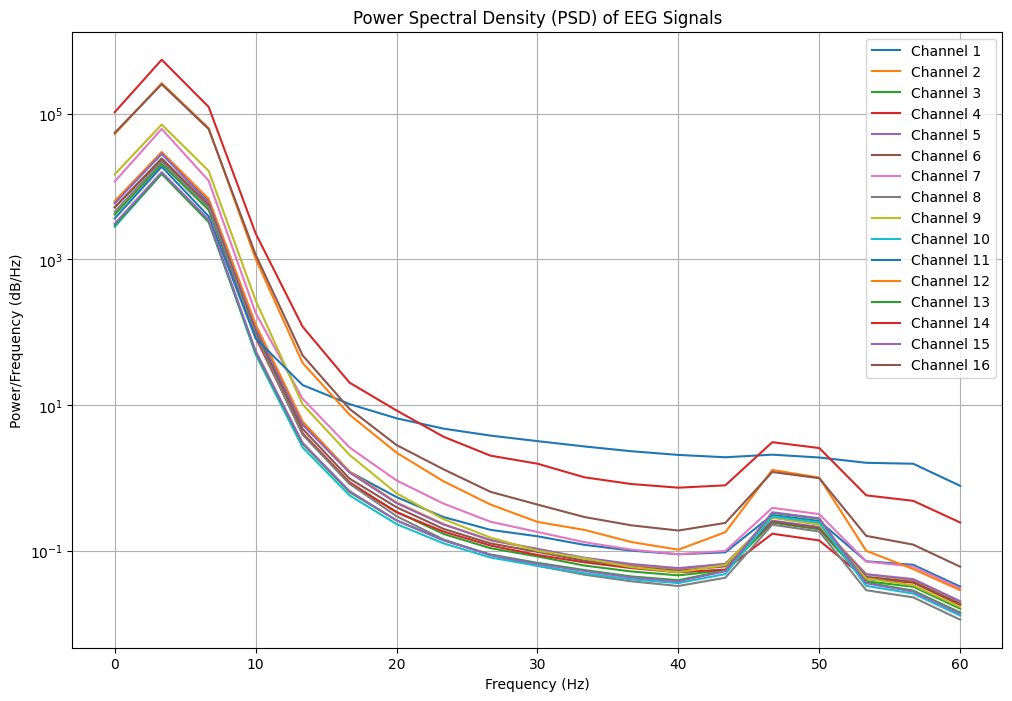

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

data = epochs.get_data(copy=True)
sfreq = epochs.info['sfreq']
n_epochs, n_channels, n_time_points = data.shape

plt.figure(figsize=(12, 8))

for channel_idx in range(n_channels):
    # Calculate PSD for the current channel
    freqs, psd = welch(data[:, channel_idx, :], fs=sfreq, axis=-1)
    
    # Average PSD across epochs
    avg_psd = np.mean(psd, axis=0)
    
    # Plot the PSD
    plt.semilogy(freqs, avg_psd, label=f'Channel {channel_idx + 1}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density (PSD) of EEG Signals')
plt.legend()
plt.grid(True)
plt.show()


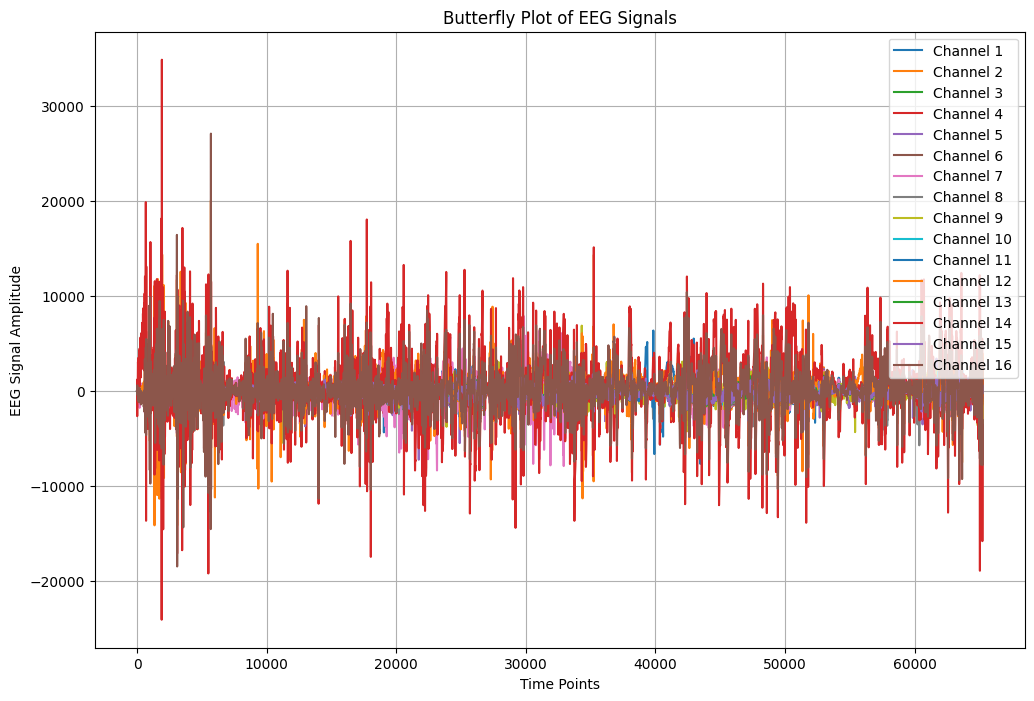

In [12]:
data = epochs.get_data(copy=True) 
n_epochs, n_channels, n_time_points = data.shape
plt.figure(figsize=(12, 8))

for channel_idx in range(n_channels):
    channel_data = data[:, channel_idx, :].flatten()
    time_points = np.arange(n_time_points * n_epochs)
    plt.plot(time_points, channel_data, label=f'Channel {channel_idx + 1}')


plt.xlabel('Time Points')
plt.ylabel('EEG Signal Amplitude')
plt.title('Butterfly Plot of EEG Signals')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import mne

eeg_data = epochs.get_data()

condition_ranges = {'lev1': (100/duration, 200/duration),
                    'lev2': (280/duration, 380/duration),
                    'lev3': (420/duration, 520/duration)}

epochs_by_condition = {}
selected_epochs = []

for condition, (start_epoch, end_epoch) in condition_ranges.items():
    start_epoch = int(start_epoch)
    end_epoch = int(end_epoch)
    condition_epochs = epochs[start_epoch:end_epoch+1].copy()
    epochs_by_condition[condition] = condition_epochs
    selected_epochs.append(condition_epochs)

selected_epochs = mne.concatenate_epochs(selected_epochs)

for condition, epoch_data in epochs_by_condition.items():
    num_epochs = len(epoch_data)
    print(f"Number of epochs for {condition}: {num_epochs}")

print(f"Total number of selected epochs: {len(selected_epochs)}")


Not setting metadata
1002 matching events found
No baseline correction applied
Number of epochs for lev1: 334
Number of epochs for lev2: 334
Number of epochs for lev3: 334
Total number of selected epochs: 1002


C:\Users\LEGION\AppData\Local\Temp\ipykernel_9472\776002152.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_data = epochs.get_data()


In [14]:

condition_of_interest = 'lev1'
epoch_array_for_condition = epochs_by_condition[condition_of_interest]
print(f"Epoch array shape for condition {condition_of_interest}: {epoch_array_for_condition.get_data().shape}")


Epoch array shape for condition lev1: (334, 16, 36)


C:\Users\LEGION\AppData\Local\Temp\ipykernel_9472\1489624503.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(f"Epoch array shape for condition {condition_of_interest}: {epoch_array_for_condition.get_data().shape}")


In [15]:
condition_of_interest = 'lev1'
epoch_array_for_condition = epochs_by_condition[condition_of_interest]

In [16]:
import pandas as pd
import numpy as np
from scipy.signal import welch



def calculate_psd_features(epoch_data, sfreq):
    psd_frequencies, psd_values = welch(epoch_data, fs=sfreq)
    psd_means = np.mean(psd_values, axis=1)  # Calculate mean PSD values for each channel
    psd_variances = np.var(psd_values, axis=1)  # Calculate variance of PSD values for each channel
    psd_std_devs = np.std(psd_values, axis=1)  # Calculate standard deviation of PSD values for each channel
    return psd_means, psd_variances, psd_std_devs

channel_names = epochs.ch_names
sfreq = epochs.info['sfreq']  # Sampling frequency

columns = [f'{feature}_{channel}' for feature in ['mean_psd', 'variance_psd', 'standarddev_psd'] for channel in channel_names]
columns.append('condition')
feature_df = pd.DataFrame(columns=columns)

def append_epoch_data(epoch_array, condition_label):
    global feature_df
    for epoch in epoch_array:
        psd_means, psd_variances, psd_std_devs = calculate_psd_features(epoch, sfreq)
        epoch_features = np.concatenate([psd_means, psd_variances, psd_std_devs])
        epoch_features = np.append(epoch_features, condition_label)
        epoch_df = pd.DataFrame([epoch_features], columns=columns)
        feature_df = pd.concat([feature_df, epoch_df], ignore_index=True)

append_epoch_data(epochs_by_condition['lev1'], 'lev1')
append_epoch_data(epochs_by_condition['lev2'], 'lev2')
append_epoch_data(epochs_by_condition['lev3'], 'lev3')

print("Shape of feature DataFrame:", feature_df.shape)
print(feature_df.head())


c:\Users\LEGION\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 36, using nperseg = 36
  warnings.warn('nperseg = {0:d} is greater than input length '


Shape of feature DataFrame: (1002, 49)
         mean_psd_Fp1        mean_psd_Fp2         mean_psd_C3  \
0  277.50892350152367   487.3179536465947   270.8020306546775   
1   329.0407127257002    273.585873822594  205.33088325312175   
2  101.69404394185732  107.17573472071092   71.23055015094266   
3  361.24421483688076  399.70998266855764   267.8696839129199   
4  115.46720715462911  161.91984868354555  128.49090173661511   

          mean_psd_C4         mean_psd_P7         mean_psd_P8  \
0  373.31728262379147   78.30340082523821   450.8703783013295   
1  1419.9324017226907   580.5772864567741  163.24302610162576   
2  34.764264123972545  149.66919909915438   80.91412575952181   
3   467.8502518473934  338.77345275607814   286.1748182474084   
4  145.41316813267494  171.74251251958108  140.05806614011473   

         mean_psd_O1         mean_psd_O2         mean_psd_F7  \
0  30.23676733406445   399.8955885228474  1898.0252747000106   
1  352.6119962096979   90.57687725161357   279.9974

In [17]:
# Rename columns using a dictionary
new_column_names = {
    'mean_psd_Fp1': 'mean_psd_Fp1',
    'mean_psd_Fp2': 'mean_psd_Fp2',
    'mean_psd_C3': 'mean_psd_C3',
    'mean_psd_C4': 'mean_psd_C4',
    'mean_psd_P7': 'mean_psd_P7',
    'mean_psd_P8': 'mean_psd_P8',
    'mean_psd_O1': 'mean_psd_O1',
    'mean_psd_O2': 'mean_psd_O2',
    'mean_psd_F7': 'mean_psd_F7',
    'mean_psd_F8': 'mean_psd_F8',
    'standarddev_psd_Fp1': 'stddev_psd_Fp1',
    'standarddev_psd_Fp2': 'stddev_psd_Fp2',
    'standarddev_psd_C3': 'stddev_psd_C3',
    'standarddev_psd_C4': 'stddev_psd_C4',
    'standarddev_psd_P7': 'stddev_psd_P7',
    'standarddev_psd_P8': 'stddev_psd_P8',
    'standarddev_psd_O1': 'stddev_psd_O1',
    'standarddev_psd_O2': 'stddev_psd_O2',
    'standarddev_psd_F7': 'stddev_psd_F7',
    'standarddev_psd_F8': 'stddev_psd_F8'
}

# Rename columns using the rename() method
feature_df.rename(columns=new_column_names, inplace=True)

# Print the DataFrame
print(feature_df.head())


         mean_psd_Fp1        mean_psd_Fp2         mean_psd_C3  \
0  277.50892350152367   487.3179536465947   270.8020306546775   
1   329.0407127257002    273.585873822594  205.33088325312175   
2  101.69404394185732  107.17573472071092   71.23055015094266   
3  361.24421483688076  399.70998266855764   267.8696839129199   
4  115.46720715462911  161.91984868354555  128.49090173661511   

          mean_psd_C4         mean_psd_P7         mean_psd_P8  \
0  373.31728262379147   78.30340082523821   450.8703783013295   
1  1419.9324017226907   580.5772864567741  163.24302610162576   
2  34.764264123972545  149.66919909915438   80.91412575952181   
3   467.8502518473934  338.77345275607814   286.1748182474084   
4  145.41316813267494  171.74251251958108  140.05806614011473   

         mean_psd_O1         mean_psd_O2         mean_psd_F7  \
0  30.23676733406445   399.8955885228474  1898.0252747000106   
1  352.6119962096979   90.57687725161357   279.9974259740043   
2  795.3756586831423  30.9

In [18]:
feature_df

,mean_psd_Fp1,mean_psd_Fp2,mean_psd_C3,mean_psd_C4,mean_psd_P7,mean_psd_P8,mean_psd_O1,mean_psd_O2,mean_psd_F7,mean_psd_F8,...,stddev_psd_O2,stddev_psd_F7,stddev_psd_F8,standarddev_psd_F3,standarddev_psd_F4,standarddev_psd_T7,standarddev_psd_T8,standarddev_psd_P3,standarddev_psd_P4,condition
0,277.50892350152367,487.3179536465947,270.8020306546775,373.31728262379147,78.30340082523821,450.8703783013295,30.23676733406445,399.8955885228474,1898.0252747000106,532.874366703581,...,1083.3242654447242,6665.359501091471,1615.0050649627183,14.40766830941455,16846.469155583847,1333.954423289834,25113.910413724014,1204.637589570455,7425.886403366165,lev1
1,329.0407127257002,273.585873822594,205.33088325312175,1419.9324017226907,580.5772864567741,163.24302610162576,352.6119962096979,90.57687725161357,279.9974259740043,68.87512850838164,...,265.8532564765079,756.7921278984084,254.11409041947294,652.2725858920455,1190.9970672376119,590.717045505423,54070.252502361196,935.158144379334,13421.573030282,lev1
2,101.69404394185732,107.17573472071092,71.23055015094266,34.764264123972545,149.66919909915438,80.91412575952181,795.3756586831423,30.973613445146714,52.71652138675503,12.319072811505604,...,82.0793676784405,181.9799659586037,32.56547155320762,166.6008477710533,2916.206983107152,94.0867388884294,7855.025496265339,168.58599819071105,1281.970938485681,lev1
3,361.24421483688076,399.70998266855764,267.8696839129199,467.8502518473934,338.77345275607814,286.1748182474084,21768.06567599927,232.47986008025137,117.02277413398114,143.46524754383992,...,837.2048482610898,376.6260794303122,474.9486859114895,223.043569770728,1740.6775818902163,581.5452799597044,20764.39786125655,753.9133421330513,8604.75384372583,lev1
4,115.46720715462911,161.91984868354555,128.49090173661511,145.41316813267494,171.74251251958108,140.05806614011473,528.3070032763483,109.61260803514922,62.17864399147921,112.30564835338174,...,288.31079729646063,167.4703269296203,330.38921848822713,411.5857944750485,223.48416014164965,147.30544682782363,8089.3076473247975,223.61046596968126,2697.302862854644,lev1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,944.2289253817681,1115.2074129940597,827.9375558258824,473.3364223530201,1415.1859019390777,921.5679169321733,932.9265572910033,1137.068955041134,1830.129048146399,393.54252659845326,...,3524.410544267483,5326.822349097595,1176.8764196117552,1556.1335178710697,7556.0505346359405,2081.6719122439918,107851.32859637607,2218.6870953542216,34195.280993469554,lev3
998,1019.5141919292392,1156.772666025396,717.0646564311126,669.9536128552472,998.8226758637734,781.2455051049576,718.4715297512405,389.3267676655345,2156.6714675174753,484.72134548903904,...,1362.774343855111,5810.376426515513,1651.2464573591715,1326.7020749217245,12785.830346781113,1827.1319905534824,103368.18585645921,1493.904415903386,38806.97506130844,lev3
999,509.3388492046842,996.2666395553995,650.5474930331548,204.53737816581665,509.0049904017785,741.8488404286231,740.3595528958787,554.8220645220258,96.89101432390537,617.5765853339086,...,2024.5228093686985,275.7495144634638,2259.50278725517,1984.4954434176916,18123.232917642716,2064.9020685589508,55745.44292741752,1998.2828043441252,20590.680950563034,lev3
1000,512.9456756975362,579.3327742237614,429.38722858452775,96.0352231334182,390.83471778451604,418.4553676944628,493.08477836496223,361.7588179302916,473.3705931060523,311.95483958527404,...,1077.0709374875005,1760.2087486261782,879.1570033919966,923.1173223507553,6354.125622102177,1222.694392762694,31831.578490366253,1015.3381400179278,11417.816186629838,lev3


In [19]:
# import matplotlib.pyplot as plt

# def plot_psd_features(psd_features, freqs, ch_names):
#     num_channels = len(ch_names)
    
#     fig, axs = plt.subplots(num_channels, figsize=(10, 6*num_channels))
#     for i, (channel_psd, channel_name) in enumerate(zip(psd_features, ch_names)):
#         axs[i].plot(freqs, channel_psd, label=channel_name)
#         axs[i].set_title(f'Power Spectral Density (PSD) for Channel {channel_name}')
#         axs[i].set_xlabel('Frequency (Hz)')
#         axs[i].set_ylabel('PSD')
#         axs[i].grid(True)
#         axs[i].legend()

#     plt.tight_layout()
#     plt.show()

# psd_frequencies, psd_values = welch(epoch_data[0], fs=sfreq)

# # Example usage:
# plot_psd_features(psd_values,  psd_frequencies, ch_names


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = feature_df.drop(columns=['condition'])
y = feature_df['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6119402985074627


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier on the training data
log_reg_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = log_reg_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.572139303482587


c:\Users\LEGION\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Split the data into features (X) and target (y)
X = feature_df.drop(columns=['condition'])
y = feature_df['condition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the classifier on the training data
gb_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = gb_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5920398009950248
